<a href="https://colab.research.google.com/github/rajivnayanc/LicensePlateDetection-HumAIn-TCS/blob/master/License_Plates_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
cd '/gdrive/My Drive/MLAlgo'

/gdrive/My Drive/MLAlgo


In [0]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

In [0]:
import cv2
from tqdm import tqdm_notebook as tqdm

In [0]:
from PIL import Image

In [0]:
import torch
import torchvision
from torchvision import transforms, utils

import os
import numpy as np

import pandas as pd
from torch.utils.data import Dataset

In [0]:
from torch.utils.data import DataLoader

In [0]:
import torch.optim as optim

In [0]:
import torch.nn as nn
import json

In [0]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline

In [0]:
import requests

# Preparing Data


In [0]:
files = open('Indian_Number_plates.json')

In [0]:
data = []
for line in open('Indian_Number_plates.json', 'r'):
    data.append(json.loads(line))
data = json.loads(json.dumps(data))

## Downloading Images from URL

In [0]:
for d in data:
  url = d['content']
  image_name = d['content'].split('/')[-1]
  print(url)
  r = requests.get(url) 
  with open(os.path.join('dataset',image_name),'wb') as f: 
      f.write(r.content) 

http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg
http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/4eb236a3-6547-4103-b46f-3756d21128a9___06-Sanjay-Dutt.jpg.jpeg
http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/84969111-2ec3-4914-b3bb-da5aaac701e7___1.jpg.jpeg
http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/52b45060-9645-47c7-882d-b69a5bf07eff___1006372d1351343820-my-new-maruti-swift-zxi-21102012241.jpg.jpeg
http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/5d08ee4a-d8e7-4fda-8959-21f263f62c25___100923d1368191518-custom-number-plates-embossedplates1.jpg.jpeg
http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/18d2b870-7817-46da-a59a-6406c1b472c9___1033.png
http://com.dataturks.a96-i23.open.s3.amazon

## Creating CSV File

In [0]:
image_width = []
image_height = []
x1 = []
y1 = []
x2 = []
y2 = []
image_names = []
for d in data:
  url = d['content']
  image_name = d['content'].split('/')[-1]
  extension = image_name.split('.')[-1]
  if extension!='gif':
    image_names.append(image_name)
    
    x1.append(d['annotation'][0]["points"][0]['x'])
    y1.append(d['annotation'][0]["points"][0]['y'])

    x2.append(d['annotation'][0]["points"][1]['x'])
    y2.append(d['annotation'][0]["points"][1]['y'])

    image_width.append(d['annotation'][0]["imageWidth"])
    image_height.append(d['annotation'][0]["imageHeight"])



In [0]:
print(len(x1),len(x2),len(y1),len(y2),len(image_width),len(image_height),len(image_names))

236 236 236 236 236 236 236


In [0]:
csv_data = {'image_name':image_names,'x1':x1,'y1':y1,'x2':x2,'y2':y2,'ImageWidth':image_width,'ImageHeight':image_height}

In [0]:
csv_data = pd.DataFrame(csv_data)

In [0]:
csv_data.to_csv('annotations.csv',index=False)

# Creating Custom Dataset Loader

## DataLoader

In [0]:
data = pd.read_csv('annotations.csv')

In [13]:
data.head()

,image_name,x1,y1,x2,y2,ImageWidth,ImageHeight
0,77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f78...,0.722084,0.587983,0.868486,0.688841,806,466
1,4eb236a3-6547-4103-b46f-3756d21128a9___06-Sanj...,0.161943,0.850780,0.582996,1.000000,494,449
2,84969111-2ec3-4914-b3bb-da5aaac701e7___1.jpg.jpeg,0.082000,0.697452,0.230000,0.828025,500,314
3,52b45060-9645-47c7-882d-b69a5bf07eff___1006372...,0.434000,0.667377,0.718000,0.765458,500,469
4,5d08ee4a-d8e7-4fda-8959-21f263f62c25___100923d...,0.208791,0.390764,0.865135,0.984014,1001,563


In [0]:
class PlateDetectionDataset(Dataset):
    def __init__(self,path,train_size = 0.9,train=True,transform = None):
      self.data = pd.read_csv(path)
      self.train,self.test = train_test_split(self.data,train_size=train_size,shuffle = True,random_state=0)
      self.ifTrain = train
      self.transform = transform

    def __len__(self):
      if self.ifTrain:
        return len(self.train)
      else:
        return len(self.test)
    
    def __getitem__(self,idx):
      if self.ifTrain:
        data = self.train.iloc[idx,:]

        image = cv2.imread(os.path.join('dataset',data['image_name']))
        image = Image.fromarray(image)
        x1 = torch.as_tensor(data['x1'])
        x2 = torch.as_tensor(data['x2'])
        y1 = torch.as_tensor(data['y1'])
        y2 = torch.as_tensor(data['y2'])

        imageWidth = torch.as_tensor(data['ImageWidth'])
        imageHeight = torch.as_tensor(data['ImageHeight'])

        if self.transform is not None:
          image = self.transform(image)

        return image,x1,y1,x2,y2,imageWidth,imageHeight

      else:
        data = self.test.iloc[idx,:]
        image = cv2.imread(os.path.join('dataset',data['image_name']))
        image = Image.fromarray(image)
        x1 = torch.as_tensor(data['x1'])
        x2 = torch.as_tensor(data['x2'])
        y1 = torch.as_tensor(data['y1'])
        y2 = torch.as_tensor(data['y2'])

        imageWidth = torch.as_tensor(data['ImageWidth'])
        imageHeight = torch.as_tensor(data['ImageHeight'])

        if self.transform is not None:
          image = self.transform(image)

        return image,x1,y1,x2,y2,imageWidth,imageHeight

## Visualization

In [0]:
transform = transforms.Compose([
  transforms.Resize((256,256)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [0]:
trainData = PlateDetectionDataset('annotations.csv',train=True,transform=transform)

In [0]:
trainDataLoader = DataLoader(trainData,batch_size = 4, shuffle=False)

In [0]:
td = iter(trainDataLoader)

In [0]:
img,x1,y1,x2,y2,imgW,imgH = td.next()
ind = 3
img,x1,y1,x2,y2,imgW,imgH = img[ind],x1[ind],y1[ind],x2[ind],y2[ind],imgW[ind],imgH[ind] 
img = np.transpose(img.numpy(),(1,2,0))
x1,y1,x2,y2,imgW,imgH = x1.item(),y1.item(),x2.item(),y2.item(),imgW.item(),imgH.item()
x1,y1,x2,y2 = x1*256,y1*256,x2*256,y2*256
step = 256//8

xc,yc = int((x1+x2)/2),int((y1+y2)/2)
X,Y = int(xc/step),int(yc/step)
im = img.copy()
ground_truth =   np.zeros((1,5,8,8))

for i in range(0,8):
  for j in range(0,8):
    x0,y0 = i*step,j*step
    x1_,y1_ = (i+1)*step,(j+1)*step
    if(i,j)==(X,Y):
      ground_truth[0,0,i,j]=1
      ground_truth[0,1,i,j]=(xc-x0)/(x1_-x0)
      ground_truth[0,2,i,j]=(yc-y0)/(y1_-y0)
      ground_truth[0,3,i,j]=(x2-xc)/256
      ground_truth[0,4,i,j]=(y2-yc)/256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


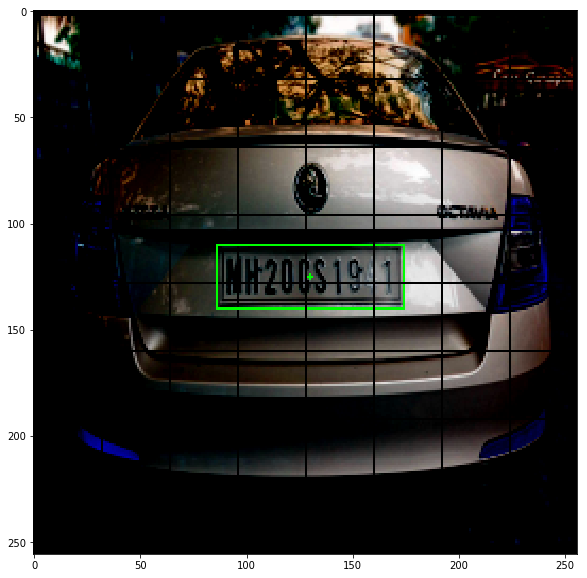

In [20]:
for i in range(0,8):
  for j in range(0,8):
    x0,y0 = i*step,j*step
    x1_,y1_ = (i+1)*step,(j+1)*step
    cv2.rectangle(im,(x0,y0),(x1_,y1_),(0,0,0),1)
    if  ground_truth[0,0,i,j]==1:
      xc = int(ground_truth[0,1,i,j]*(x1_ - x0) + x0)
      yc = int(ground_truth[0,2,i,j]*(y1_ - y0) + y0)
      cv2.circle(im,(xc,yc),1,(0,255,0),-1)
      half_x = int(ground_truth[0,3,i,j]*256)
      half_y = int(ground_truth[0,4,i,j]*256)
      cv2.rectangle(im,(xc-half_x,yc-half_y),(xc+half_x,yc+half_y),(0,255,0),1)

plt.figure(figsize=(10,10))
plt.imshow(im)

# Model

In [0]:
class PlateDetector(nn.Module):
  def __init__(self):
    super(PlateDetector,self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3,192,7,stride=1,padding=3),
        nn.BatchNorm2d(192),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(192,256,3,stride=1,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256,512,3,stride=1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(512,1024,3,stride=1,padding=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(0.3),
        nn.MaxPool2d(2,2),

        nn.Conv2d(1024,1024,3,stride=1,padding=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(0.3),
        nn.MaxPool2d(2,2),

        nn.Conv2d(1024,1024,3,stride=1,padding=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(0.3),   
    )

    self.regression = nn.Sequential(
        nn.Linear(1024*8*8,4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096,320),
        nn.Sigmoid()
    )

  def forward(self,x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    x = self.regression(x)
    x = x.view(x.size(0),5,8,8)
    return x

In [0]:
model = PlateDetector()

In [0]:
from torchsummary import summary

In [24]:
summary(model.cuda(),(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 192, 256, 256]          28,416
       BatchNorm2d-2        [-1, 192, 256, 256]             384
              ReLU-3        [-1, 192, 256, 256]               0
         MaxPool2d-4        [-1, 192, 128, 128]               0
            Conv2d-5        [-1, 256, 128, 128]         442,624
       BatchNorm2d-6        [-1, 256, 128, 128]             512
              ReLU-7        [-1, 256, 128, 128]               0
         MaxPool2d-8          [-1, 256, 64, 64]               0
            Conv2d-9          [-1, 512, 64, 64]       1,180,160
      BatchNorm2d-10          [-1, 512, 64, 64]           1,024
             ReLU-11          [-1, 512, 64, 64]               0
        MaxPool2d-12          [-1, 512, 32, 32]               0
           Conv2d-13         [-1, 1024, 32, 32]       4,719,616
      BatchNorm2d-14         [-1, 1024,

# Training

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
model = PlateDetector()
model = model.to(device)
# model.load_state_dict(torch.load('weight.pth'))

In [0]:
def iou_calc(pred,ground_truth):
  iou = torch.zeros((1,8,8))
  step = 256//8
  for i in range(8):
    for j in range(8):
      x0,y0 = i*step,j*step
      x1_,y1_ = (i+1)*step,(j+1)*step
      if ground_truth[0,0,i,j]==1:
        xc1 = int(ground_truth[0,1,i,j]*(x1_-x0) + x0)
        yc1 = int(ground_truth[0,2,i,j]*(y1_ - y0) + y0)
        half_x1 = int(ground_truth[0,3,i,j]*256)
        half_y1 = int(ground_truth[0,4,i,j]*256)

        xc2 = int(pred[0,1,i,j]*(x1_-x0) + x0)
        yc2 = int(pred[0,2,i,j]*(y1_ - y0) + y0)
        half_x2 = int(pred[0,3,i,j]*256)
        half_y2 = int(pred[0,4,i,j]*256)

        X1_A = xc1-half_x1
        X2_A = xc1+half_x1

        Y1_A = yc1-half_y1
        Y2_A = yc1+half_y1

        X1_B = xc2-half_x2
        X2_B = xc2+half_x2

        Y1_B = yc2-half_y2
        Y2_B = yc2+half_y2

        XA = max(X1_A,X1_B)
        YA =max(Y1_A,Y1_B)

        XB = min(X2_A,X2_B)
        YB = min(Y2_A,Y2_B)

        interArea = max(0, XB - XA + 1) * max(0, YB - YA + 1)

        areaA = (X2_A-X1_A + 1)*(Y2_A-Y1_A+1)
        areaB = (X2_B-X1_B + 1)*(Y2_B-Y1_B+1)

        iou[0,i,j] = interArea/float(areaA+areaB-interArea)
  return iou.to(device)


In [0]:
def yolo_loss(pred,target):
  
  a = torch.sum(target[0,0,:,:]*torch.pow((pred[0,0,:,:]-target[0,0,:,:]),2)*iou_calc(pred,target))
  # print
  b = 0.5*torch.sum((1-target[0,0,:,:])*torch.pow((pred[0,0,:,:]-target[0,0,:,:]),2))
  # print(b)
  c = 5*torch.sum( target[0,0,:,:] * (torch.pow((pred[0,1,:,:]-target[0,1,:,:]),2) + torch.pow((pred[0,2,:,:]-target[0,2,:,:]),2)))
  # print(c)
  d = 5*torch.sum( target[0,0,:,:] * (torch.pow(( torch.sqrt(pred[0,3,:,:])-torch.sqrt(target[0,3,:,:])),2)
         + torch.pow((torch.sqrt(pred[0,4,:,:])-torch.sqrt(target[0,4,:,:])),2)))
  # print(d)
  return (a+b+c+d)

In [0]:
opt = optim.RMSprop(model.parameters(),lr=0.000001,weight_decay=0.8)
loss_fn = yolo_loss

In [0]:
testData =  PlateDetectionDataset('annotations.csv',train=False,transform=transform)
testDataLoader = DataLoader(testData,batch_size = 1, shuffle=False)

In [0]:
trainData =  PlateDetectionDataset('annotations.csv',train_size = 0.7,train=True,transform=transform)
trainLoader1 = DataLoader(trainData,batch_size = 1, shuffle=True)

In [0]:
loss_arr = []
val_loss_arr = []

In [0]:
min_val_loss = 100000.0

In [0]:
min_val_loss

100000.0

In [0]:
num_epochs = 250
lr = 0.0001
kk = 0
for epoch in range(1,num_epochs+1):
  loss_item = 0.0
  val_loss_item = 0.0
  model.train()
  for i,data in tqdm(enumerate(trainLoader1),total=len(trainLoader1),unit='Images'):
    img,x1,y1,x2,y2,imgW,imgH = data
    ind = 0
    img,x1,y1,x2,y2,imgW,imgH = img[ind],x1[ind],y1[ind],x2[ind],y2[ind],imgW[ind],imgH[ind] 
    x1,y1,x2,y2,imgW,imgH = x1.item(),y1.item(),x2.item(),y2.item(),imgW.item(),imgH.item()
    x1,y1,x2,y2 = x1*256,y1*256,x2*256,y2*256
    step = 256//8

    xc,yc = int((x1+x2)/2),int((y1+y2)/2)
    X,Y = int(xc/step),int(yc/step)

    ground_truth =   torch.zeros((1,5,8,8))

    for i in range(0,8):
      for j in range(0,8):
        x0,y0 = i*step,j*step
        x1_,y1_ = (i+1)*step,(j+1)*step
        if(i,j)==(X,Y):
          ground_truth[0,0,i,j]=1
          ground_truth[0,1,i,j]=(xc-x0)/(x1_-x0)
          ground_truth[0,2,i,j]=(yc-y0)/(y1_-y0)
          ground_truth[0,3,i,j]=(x2-xc)/256
          ground_truth[0,4,i,j]=(y2-yc)/256

    ground_truth = ground_truth.to(device)
    opt.zero_grad()
    img = img.to(device)
    output = model(img.unsqueeze(0))
    # print(output)
    loss = loss_fn(output,ground_truth)
    # print(loss.item())
    loss.backward()
    opt.step()
    
    loss_item+=loss.item()
    # print(loss_item)
  loss_arr.append(loss_item/len(trainLoader1))


  model.eval()
  for i,data in enumerate(testDataLoader):
    img,x1,y1,x2,y2,imgW,imgH = data
    ind = 0
    img,x1,y1,x2,y2,imgW,imgH = img[ind],x1[ind],y1[ind],x2[ind],y2[ind],imgW[ind],imgH[ind] 
    x1,y1,x2,y2,imgW,imgH = x1.item(),y1.item(),x2.item(),y2.item(),imgW.item(),imgH.item()
    x1,y1,x2,y2 = x1*256,y1*256,x2*256,y2*256
    step = 256//8

    xc,yc = int((x1+x2)/2),int((y1+y2)/2)
    X,Y = int(xc/step),int(yc/step)

    ground_truth =   torch.zeros((1,5,8,8))

    for i in range(0,8):
      for j in range(0,8):
        x0,y0 = i*step,j*step
        x1_,y1_ = (i+1)*step,(j+1)*step
        if(i,j)==(X,Y):
          ground_truth[0,0,i,j]=1
          ground_truth[0,1,i,j]=(xc-x0)/(x1_-x0)
          ground_truth[0,2,i,j]=(yc-y0)/(y1_-y0)
          ground_truth[0,3,i,j]=(x2-xc)/256
          ground_truth[0,4,i,j]=(y2-yc)/256

    ground_truth = ground_truth.to(device)
    opt.zero_grad()
    img = img.to(device)
    output = model(img.unsqueeze(0))
    # print(output)
    loss = loss_fn(output,ground_truth)
    
    val_loss_item+=loss.item()

  if(val_loss_item<min_val_loss):
    print("Validation Loss decreased from {} to {}".format(min_val_loss,val_loss_item))
    min_val_loss = val_loss_item
    torch.save(model.state_dict(), 'weight.pth')
  
  
  model.load_state_dict(torch.load('weight.pth'))
 

  val_loss_arr.append(val_loss_item/len(testDataLoader))
  print("Epoch: {}/{}, Training Loss:{}  Validation Loss: {}Learning Rate:{}"
  .format(epoch,num_epochs,loss_item/len(trainLoader1),
        val_loss_item/len(testDataLoader),lr))
    

Epoch: 1/250, Training Loss:0.7795965993946249  Validation Loss: 1.4800783668955166Learning Rate:0.0001


Epoch: 2/250, Training Loss:0.7508185085022088  Validation Loss: 1.4652639689544837Learning Rate:0.0001


Validation Loss decreased from 34.49589878320694 to 34.38060477375984
Epoch: 3/250, Training Loss:0.7512181360613216  Validation Loss: 1.43252519890666Learning Rate:0.0001


Epoch: 4/250, Training Loss:0.6858583742018902  Validation Loss: 1.4648451519509156Learning Rate:0.0001


Epoch: 5/250, Training Loss:0.6905260518644796  Validation Loss: 1.5751749103267987Learning Rate:0.0001


Epoch: 6/250, Training Loss:0.6739331165949504  Validation Loss: 1.50605392207702Learning Rate:0.0001


Epoch: 7/250, Training Loss:0.6924705728436962  Validation Loss: 1.5187508737047513Learning Rate:0.0001


Epoch: 8/250, Training Loss:0.6900385800636176  Validation Loss: 1.496728892127673Learning Rate:0.0001


Epoch: 9/250, Training Loss:0.7025739501823078  Validation Loss: 1.475284316887458Learning Rate:0.0001


Epoch: 10/250, Training Loss:0.6875811724951773  Validation Loss: 1.504280040661494Learning Rate:0.0001


Epoch: 11/250, Training Loss:0.694789997736613  Validation Loss: 1.561816729605198Learning Rate:0.0001


Epoch: 12/250, Training Loss:0.6874534267367739  Validation Loss: 1.6202688713868458Learning Rate:0.0001


Epoch: 13/250, Training Loss:0.6810612212527882  Validation Loss: 1.4687609759469826Learning Rate:0.0001


Epoch: 14/250, Training Loss:0.6963338898889946  Validation Loss: 1.4338629295428593Learning Rate:0.0001


Epoch: 15/250, Training Loss:0.6970920663891417  Validation Loss: 1.6006949146588643Learning Rate:0.0001


Epoch: 16/250, Training Loss:0.6911439693335331  Validation Loss: 1.582766796151797Learning Rate:0.0001


Epoch: 17/250, Training Loss:0.6761584923122869  Validation Loss: 1.650404858092467Learning Rate:0.0001


Epoch: 18/250, Training Loss:0.6971672303748854  Validation Loss: 1.4694146116574605Learning Rate:0.0001


Epoch: 19/250, Training Loss:0.6965397161967827  Validation Loss: 1.538326879342397Learning Rate:0.0001


Validation Loss decreased from 34.38060477375984 to 34.195907562971115
Epoch: 20/250, Training Loss:0.6916178970625906  Validation Loss: 1.4248294817904632Learning Rate:0.0001


Epoch: 21/250, Training Loss:0.6648307767781344  Validation Loss: 1.4951905546089013Learning Rate:0.0001


Epoch: 22/250, Training Loss:0.6847585840658708  Validation Loss: 1.539256011446317Learning Rate:0.0001


Epoch: 23/250, Training Loss:0.6729118255051699  Validation Loss: 1.4316556739310424Learning Rate:0.0001


Epoch: 24/250, Training Loss:0.6828840819272128  Validation Loss: 1.5094217384854953Learning Rate:0.0001


Epoch: 25/250, Training Loss:0.6765952252077334  Validation Loss: 1.4882360870639484Learning Rate:0.0001


Epoch: 26/250, Training Loss:0.6720265052535317  Validation Loss: 1.426348339766264Learning Rate:0.0001


Epoch: 27/250, Training Loss:0.6738089088237647  Validation Loss: 1.4381170173486073Learning Rate:0.0001


Epoch: 28/250, Training Loss:0.6686405013004939  Validation Loss: 1.5620860705773036Learning Rate:0.0001


Epoch: 29/250, Training Loss:0.6860877342296369  Validation Loss: 1.4906149705251057Learning Rate:0.0001


Epoch: 30/250, Training Loss:0.6850535555319353  Validation Loss: 1.5531695038080215Learning Rate:0.0001


Epoch: 31/250, Training Loss:0.6730433160608466  Validation Loss: 1.4646183128158252Learning Rate:0.0001


Epoch: 32/250, Training Loss:0.655303670240171  Validation Loss: 1.4652306971450646Learning Rate:0.0001


Epoch: 33/250, Training Loss:0.6639716090578022  Validation Loss: 1.5246619681517284Learning Rate:0.0001


Epoch: 34/250, Training Loss:0.6785735272096866  Validation Loss: 1.5585719322164853Learning Rate:0.0001


Validation Loss decreased from 34.195907562971115 to 34.107753932476044
Epoch: 35/250, Training Loss:0.679866253787821  Validation Loss: 1.4211564138531685Learning Rate:0.0001


Epoch: 36/250, Training Loss:0.670814833225626  Validation Loss: 1.4838206072648366Learning Rate:0.0001


Epoch: 37/250, Training Loss:0.6450566300840089  Validation Loss: 1.5007868682344754Learning Rate:0.0001


Epoch: 38/250, Training Loss:0.6697085415775126  Validation Loss: 1.4537634328007698Learning Rate:0.0001


Epoch: 39/250, Training Loss:0.6712204586375844  Validation Loss: 1.478396678964297Learning Rate:0.0001


Epoch: 40/250, Training Loss:0.6630811868291913  Validation Loss: 1.4478646889328957Learning Rate:0.0001


Epoch: 41/250, Training Loss:0.6706891990972288  Validation Loss: 1.5042652239402134Learning Rate:0.0001


Epoch: 42/250, Training Loss:0.6344150116949371  Validation Loss: 1.5023723219831784Learning Rate:0.0001


Epoch: 43/250, Training Loss:0.6603025425564159  Validation Loss: 1.448868711789449Learning Rate:0.0001


Epoch: 44/250, Training Loss:0.6539695007331443  Validation Loss: 1.43533539523681Learning Rate:0.0001


Epoch: 45/250, Training Loss:0.6676716282512203  Validation Loss: 1.6002785290280979Learning Rate:0.0001


Epoch: 46/250, Training Loss:0.6524511574795752  Validation Loss: 1.4965902703503768Learning Rate:0.0001


Epoch: 47/250, Training Loss:0.668952019015948  Validation Loss: 1.5234579394261043Learning Rate:0.0001


Epoch: 48/250, Training Loss:0.6614408989747366  Validation Loss: 1.5391009797652562Learning Rate:0.0001


Epoch: 49/250, Training Loss:0.6708681223970471  Validation Loss: 1.5229978933930397Learning Rate:0.0001


Epoch: 50/250, Training Loss:0.6747771870006215  Validation Loss: 1.6339799985289574Learning Rate:0.0001


Epoch: 51/250, Training Loss:0.6553282626650551  Validation Loss: 1.5339300036430359Learning Rate:0.0001


Epoch: 52/250, Training Loss:0.6635266503601364  Validation Loss: 1.4883876020709674Learning Rate:0.0001


Epoch: 53/250, Training Loss:0.6630248510476314  Validation Loss: 1.4652178982893627Learning Rate:0.0001


Epoch: 54/250, Training Loss:0.6506857555924039  Validation Loss: 1.4628524035215378Learning Rate:0.0001


Epoch: 55/250, Training Loss:0.6668804773778626  Validation Loss: 1.5174756174286206Learning Rate:0.0001


Epoch: 56/250, Training Loss:0.6592367106314861  Validation Loss: 1.4814137717088063Learning Rate:0.0001


Epoch: 57/250, Training Loss:0.6714837179039463  Validation Loss: 1.5297168046236038Learning Rate:0.0001


Epoch: 58/250, Training Loss:0.6749226878989827  Validation Loss: 1.553261975447337Learning Rate:0.0001


Epoch: 59/250, Training Loss:0.666520271969564  Validation Loss: 1.4679220964511235Learning Rate:0.0001


Epoch: 60/250, Training Loss:0.6666158491914923  Validation Loss: 1.52935737123092Learning Rate:0.0001


Validation Loss decreased from 34.107753932476044 to 33.95242491364479
Epoch: 61/250, Training Loss:0.6525623279990572  Validation Loss: 1.4146843714018662Learning Rate:0.0001


Epoch: 62/250, Training Loss:0.6636945534836162  Validation Loss: 1.50913750876983Learning Rate:0.0001


Epoch: 63/250, Training Loss:0.6635983999931451  Validation Loss: 1.4798873588442802Learning Rate:0.0001


Epoch: 64/250, Training Loss:0.6580984676426107  Validation Loss: 1.5629041641950607Learning Rate:0.0001


Epoch: 65/250, Training Loss:0.6713019060366081  Validation Loss: 1.460179661711057Learning Rate:0.0001


Epoch: 66/250, Training Loss:0.6511876183928865  Validation Loss: 1.4941209343572457Learning Rate:0.0001


Epoch: 67/250, Training Loss:0.661728406494314  Validation Loss: 1.476877321799596Learning Rate:0.0001


Epoch: 68/250, Training Loss:0.6469289993697946  Validation Loss: 1.48725609232982Learning Rate:0.0001


Epoch: 69/250, Training Loss:0.6488254973382661  Validation Loss: 1.5245356857776642Learning Rate:0.0001


Epoch: 70/250, Training Loss:0.6686362457997871  Validation Loss: 1.5590184306104977Learning Rate:0.0001


Epoch: 71/250, Training Loss:0.6771835348822853  Validation Loss: 1.5024375542998314Learning Rate:0.0001


Epoch: 72/250, Training Loss:0.6599518995393406  Validation Loss: 1.4435612646241982Learning Rate:0.0001


Epoch: 73/250, Training Loss:0.6577514693592534  Validation Loss: 1.427206914871931Learning Rate:0.0001


Epoch: 74/250, Training Loss:0.6768870583086303  Validation Loss: 1.4872052396337192Learning Rate:0.0001


Epoch: 75/250, Training Loss:0.6507987688888203  Validation Loss: 1.5204526682694752Learning Rate:0.0001


Epoch: 76/250, Training Loss:0.6627735579555685  Validation Loss: 1.5503083020448685Learning Rate:0.0001


Epoch: 77/250, Training Loss:0.6789616556781711  Validation Loss: 1.5303779641787212Learning Rate:0.0001


Epoch: 78/250, Training Loss:0.6724151506568447  Validation Loss: 1.667922702928384Learning Rate:0.0001


Epoch: 79/250, Training Loss:0.6653949421463591  Validation Loss: 1.6154210567474365Learning Rate:0.0001


Epoch: 80/250, Training Loss:0.6418194199150259  Validation Loss: 1.4774646386504173Learning Rate:0.0001


Epoch: 81/250, Training Loss:0.6701770223451383  Validation Loss: 1.4610102971394856Learning Rate:0.0001


Epoch: 82/250, Training Loss:0.6726592456752604  Validation Loss: 1.4706230089068413Learning Rate:0.0001


Epoch: 83/250, Training Loss:0.6564986818667614  Validation Loss: 1.47537266711394Learning Rate:0.0001


Epoch: 84/250, Training Loss:0.6634995621262174  Validation Loss: 1.5407692566514015Learning Rate:0.0001


Epoch: 85/250, Training Loss:0.6634368762825474  Validation Loss: 1.5225726614395778Learning Rate:0.0001


Epoch: 86/250, Training Loss:0.671766815402291  Validation Loss: 1.66074550896883Learning Rate:0.0001


Epoch: 87/250, Training Loss:0.6878699858080257  Validation Loss: 1.6429144193728764Learning Rate:0.0001


Epoch: 88/250, Training Loss:0.6762159376433401  Validation Loss: 1.5935489883025487Learning Rate:0.0001


Epoch: 89/250, Training Loss:0.6637273878762217  Validation Loss: 1.5826347718636196Learning Rate:0.0001


Epoch: 90/250, Training Loss:0.6768919962825197  Validation Loss: 1.4785236517588298Learning Rate:0.0001


Epoch: 91/250, Training Loss:0.6530398355288939  Validation Loss: 1.4362253211438656Learning Rate:0.0001


Epoch: 92/250, Training Loss:0.6496302976752772  Validation Loss: 1.4739487941066425Learning Rate:0.0001


Epoch: 93/250, Training Loss:0.6644878445249616  Validation Loss: 1.4666530266404152Learning Rate:0.0001


Epoch: 94/250, Training Loss:0.6657372689608372  Validation Loss: 1.4679646516839664Learning Rate:0.0001


Epoch: 95/250, Training Loss:0.6657838946039026  Validation Loss: 1.499491348862648Learning Rate:0.0001


Epoch: 96/250, Training Loss:0.6422105202169129  Validation Loss: 1.466540351510048Learning Rate:0.0001


Epoch: 97/250, Training Loss:0.6665557165940602  Validation Loss: 1.5020933089156945Learning Rate:0.0001


Epoch: 98/250, Training Loss:0.6688892826889501  Validation Loss: 1.5932820960879326Learning Rate:0.0001


Epoch: 99/250, Training Loss:0.6615358478192127  Validation Loss: 1.4397446451087792Learning Rate:0.0001


Epoch: 100/250, Training Loss:0.6733148069092721  Validation Loss: 1.5420861418048541Learning Rate:0.0001


Epoch: 101/250, Training Loss:0.6690527442729834  Validation Loss: 1.4774628455440204Learning Rate:0.0001


Epoch: 102/250, Training Loss:0.668700856421933  Validation Loss: 1.5701282719771068Learning Rate:0.0001


Epoch: 103/250, Training Loss:0.656238234946222  Validation Loss: 1.571133591234684Learning Rate:0.0001


Epoch: 104/250, Training Loss:0.6553832659215638  Validation Loss: 1.4151528750856717Learning Rate:0.0001


Epoch: 105/250, Training Loss:0.6496638962716768  Validation Loss: 1.5547043556968372Learning Rate:0.0001


Epoch: 106/250, Training Loss:0.6633656312118877  Validation Loss: 1.7919769262274106Learning Rate:0.0001


Epoch: 107/250, Training Loss:0.6671369538162694  Validation Loss: 1.5891434972484906Learning Rate:0.0001


Epoch: 108/250, Training Loss:0.6531330068906148  Validation Loss: 1.4849063406387966Learning Rate:0.0001


Epoch: 109/250, Training Loss:0.6673130441795696  Validation Loss: 1.449454413106044Learning Rate:0.0001


Epoch: 110/250, Training Loss:0.6714600349917557  Validation Loss: 1.5034975459178288Learning Rate:0.0001


Epoch: 111/250, Training Loss:0.663767578385093  Validation Loss: 1.5021338587005932Learning Rate:0.0001


Epoch: 112/250, Training Loss:0.6784671411369786  Validation Loss: 1.5137000903487206Learning Rate:0.0001


Epoch: 113/250, Training Loss:0.6741981847719712  Validation Loss: 1.472094898422559Learning Rate:0.0001


Epoch: 114/250, Training Loss:0.6717031460819822  Validation Loss: 1.5248240182797115Learning Rate:0.0001


Epoch: 115/250, Training Loss:0.6655593344659516  Validation Loss: 1.579323577384154Learning Rate:0.0001


Epoch: 116/250, Training Loss:0.6676769928498701  Validation Loss: 1.4719422707955043Learning Rate:0.0001


Epoch: 117/250, Training Loss:0.6706368988210505  Validation Loss: 1.5452415744463603Learning Rate:0.0001


Epoch: 118/250, Training Loss:0.6755942304025997  Validation Loss: 1.5613875115911167Learning Rate:0.0001


Epoch: 119/250, Training Loss:0.6860305041977853  Validation Loss: 1.4676161780953407Learning Rate:0.0001


Epoch: 120/250, Training Loss:0.6666503736467072  Validation Loss: 1.4368856276075046Learning Rate:0.0001


Epoch: 121/250, Training Loss:0.6606154560139685  Validation Loss: 1.4637725551923115Learning Rate:0.0001


Epoch: 122/250, Training Loss:0.6573085017276533  Validation Loss: 1.4893157345553238Learning Rate:0.0001


Epoch: 123/250, Training Loss:0.6646732079260277  Validation Loss: 1.6117194145917892Learning Rate:0.0001


Epoch: 124/250, Training Loss:0.6650818216078209  Validation Loss: 1.5251393839716911Learning Rate:0.0001


Epoch: 125/250, Training Loss:0.6586066329117978  Validation Loss: 1.530676710108916Learning Rate:0.0001


Epoch: 126/250, Training Loss:0.6672145133668727  Validation Loss: 1.518631915251414Learning Rate:0.0001


Epoch: 127/250, Training Loss:0.6645528545885375  Validation Loss: 1.5433733935157459Learning Rate:0.0001


Epoch: 128/250, Training Loss:0.6658137381076813  Validation Loss: 1.532189833621184Learning Rate:0.0001


Epoch: 129/250, Training Loss:0.6478944634849375  Validation Loss: 1.5425635104378064Learning Rate:0.0001


Epoch: 130/250, Training Loss:0.6613019348093958  Validation Loss: 1.5464661965767543Learning Rate:0.0001


Epoch: 131/250, Training Loss:0.6584467962835774  Validation Loss: 1.4570398355523746Learning Rate:0.0001


Epoch: 132/250, Training Loss:0.6595366598078699  Validation Loss: 1.5600463102261226Learning Rate:0.0001


Epoch: 133/250, Training Loss:0.6774762601563424  Validation Loss: 1.4844473352034886Learning Rate:0.0001


Epoch: 134/250, Training Loss:0.6669508932214795  Validation Loss: 1.5352848172187805Learning Rate:0.0001


Epoch: 135/250, Training Loss:0.6593904026530005  Validation Loss: 1.5954770172635715Learning Rate:0.0001


Epoch: 136/250, Training Loss:0.6511446261044704  Validation Loss: 1.5643385499715805Learning Rate:0.0001


Epoch: 137/250, Training Loss:0.6592266792600805  Validation Loss: 1.5704207321008046Learning Rate:0.0001


Epoch: 138/250, Training Loss:0.6702931392373461  Validation Loss: 1.4597769230604172Learning Rate:0.0001


Epoch: 139/250, Training Loss:0.672671892968091  Validation Loss: 1.4986983711520832Learning Rate:0.0001


Epoch: 140/250, Training Loss:0.6593012282342622  Validation Loss: 1.5192389711737633Learning Rate:0.0001


Epoch: 141/250, Training Loss:0.6626826975381735  Validation Loss: 1.4538445236782234Learning Rate:0.0001


Epoch: 142/250, Training Loss:0.6542956705346252  Validation Loss: 1.4393270040551822Learning Rate:0.0001


Epoch: 143/250, Training Loss:0.6678723101363038  Validation Loss: 1.6686087598403294Learning Rate:0.0001


Epoch: 144/250, Training Loss:0.6672777422449806  Validation Loss: 1.5536457647879918Learning Rate:0.0001


Epoch: 145/250, Training Loss:0.6521993167472608  Validation Loss: 1.438207743068536Learning Rate:0.0001


Epoch: 146/250, Training Loss:0.6686237199739976  Validation Loss: 1.4782556655506294Learning Rate:0.0001


Epoch: 147/250, Training Loss:0.6547416808930311  Validation Loss: 1.728909191985925Learning Rate:0.0001


Epoch: 148/250, Training Loss:0.6484226923097264  Validation Loss: 1.486641988158226Learning Rate:0.0001


Epoch: 149/250, Training Loss:0.6781477738510479  Validation Loss: 1.4658730775117874Learning Rate:0.0001


Epoch: 150/250, Training Loss:0.6790043019887173  Validation Loss: 1.503186896443367Learning Rate:0.0001


Epoch: 151/250, Training Loss:0.6488975472522505  Validation Loss: 1.5003958344459534Learning Rate:0.0001


Epoch: 152/250, Training Loss:0.6706922908624013  Validation Loss: 1.5317162747184436Learning Rate:0.0001


Epoch: 153/250, Training Loss:0.681330698186701  Validation Loss: 1.5446215569972992Learning Rate:0.0001


Epoch: 154/250, Training Loss:0.6618379091674631  Validation Loss: 1.5088654110829036Learning Rate:0.0001


Epoch: 155/250, Training Loss:0.6690842054106972  Validation Loss: 1.4915404965480168Learning Rate:0.0001


Epoch: 156/250, Training Loss:0.6662531029997449  Validation Loss: 1.5107100456953049Learning Rate:0.0001


Epoch: 157/250, Training Loss:0.6565947599483258  Validation Loss: 1.4869085140526295Learning Rate:0.0001


Epoch: 158/250, Training Loss:0.6635335329807166  Validation Loss: 1.4653707245985668Learning Rate:0.0001


Epoch: 159/250, Training Loss:0.6702270451820258  Validation Loss: 1.5100053176283836Learning Rate:0.0001


Epoch: 160/250, Training Loss:0.6818091928958893  Validation Loss: 1.5319804102182388Learning Rate:0.0001


Epoch: 161/250, Training Loss:0.6702400895682248  Validation Loss: 1.6232221176226933Learning Rate:0.0001


Epoch: 162/250, Training Loss:0.6535886197379142  Validation Loss: 1.5477357357740402Learning Rate:0.0001


Epoch: 163/250, Training Loss:0.6633487183036226  Validation Loss: 1.4681046555439632Learning Rate:0.0001


Epoch: 164/250, Training Loss:0.6700416505336761  Validation Loss: 1.4287131776412327Learning Rate:0.0001


Epoch: 165/250, Training Loss:0.6729680283503099  Validation Loss: 1.5159259587526321Learning Rate:0.0001


Epoch: 166/250, Training Loss:0.6820745132186196  Validation Loss: 1.720205381512642Learning Rate:0.0001


Epoch: 167/250, Training Loss:0.6485921349489328  Validation Loss: 1.8401912301778793Learning Rate:0.0001


Epoch: 168/250, Training Loss:0.6640360502582607  Validation Loss: 1.4839004998405774Learning Rate:0.0001


Epoch: 169/250, Training Loss:0.6666690300811421  Validation Loss: 1.5393093799551327Learning Rate:0.0001


Epoch: 170/250, Training Loss:0.6712939696781564  Validation Loss: 1.575249120593071Learning Rate:0.0001


Epoch: 171/250, Training Loss:0.665210166031664  Validation Loss: 1.4680442959070206Learning Rate:0.0001


Epoch: 172/250, Training Loss:0.658980105862473  Validation Loss: 1.4860410715142887Learning Rate:0.0001


Epoch: 173/250, Training Loss:0.6689818628809668  Validation Loss: 1.6156187454859416Learning Rate:0.0001


Epoch: 174/250, Training Loss:0.6732615917017966  Validation Loss: 1.4297270588576794Learning Rate:0.0001


Epoch: 175/250, Training Loss:0.6841150276588671  Validation Loss: 1.6994536792238553Learning Rate:0.0001


Epoch: 176/250, Training Loss:0.6512505726380782  Validation Loss: 1.5510581533114116Learning Rate:0.0001


Epoch: 177/250, Training Loss:0.6712224460009373  Validation Loss: 1.6294125219186146Learning Rate:0.0001


Epoch: 178/250, Training Loss:0.6778194161075535  Validation Loss: 1.4775214369098346Learning Rate:0.0001


Epoch: 179/250, Training Loss:0.6739975975318389  Validation Loss: 1.5014046430587769Learning Rate:0.0001


Epoch: 180/250, Training Loss:0.675863769289219  Validation Loss: 1.6001765380303066Learning Rate:0.0001


Epoch: 181/250, Training Loss:0.6745514909426371  Validation Loss: 1.6093458831310272Learning Rate:0.0001


Epoch: 182/250, Training Loss:0.6789228700327151  Validation Loss: 1.6003526548544567Learning Rate:0.0001


Epoch: 183/250, Training Loss:0.668919484723698  Validation Loss: 1.4929235155383747Learning Rate:0.0001


Epoch: 184/250, Training Loss:0.6802177882555759  Validation Loss: 1.5151423861583073Learning Rate:0.0001


Epoch: 185/250, Training Loss:0.6500678240349799  Validation Loss: 1.4356850969294708Learning Rate:0.0001


Epoch: 186/250, Training Loss:0.6660942485838225  Validation Loss: 1.5741132150093715Learning Rate:0.0001


Epoch: 187/250, Training Loss:0.671302568731886  Validation Loss: 1.56108408421278Learning Rate:0.0001


Epoch: 188/250, Training Loss:0.6824402415391171  Validation Loss: 1.528141585489114Learning Rate:0.0001


Epoch: 189/250, Training Loss:0.6552325318257014  Validation Loss: 1.5248358969887097Learning Rate:0.0001


Epoch: 190/250, Training Loss:0.6607915038412268  Validation Loss: 1.5213794534405072Learning Rate:0.0001


Epoch: 191/250, Training Loss:0.6776988524379153  Validation Loss: 1.4275204837322235Learning Rate:0.0001


Epoch: 192/250, Training Loss:0.655939984050664  Validation Loss: 1.4324983023107052Learning Rate:0.0001


Epoch: 193/250, Training Loss:0.6792146070436997  Validation Loss: 1.4955932026108105Learning Rate:0.0001


Epoch: 194/250, Training Loss:0.6555302903507695  Validation Loss: 1.647660307586193Learning Rate:0.0001


Epoch: 195/250, Training Loss:0.6684852743690665  Validation Loss: 1.4269597716629505Learning Rate:0.0001


Epoch: 196/250, Training Loss:0.6668052406022043  Validation Loss: 1.4551470888157685Learning Rate:0.0001


Epoch: 197/250, Training Loss:0.6494610352046561  Validation Loss: 1.4949168985088666Learning Rate:0.0001


Epoch: 198/250, Training Loss:0.6689694754102014  Validation Loss: 1.5709049254655838Learning Rate:0.0001


Epoch: 199/250, Training Loss:0.6790129620017428  Validation Loss: 1.4864059512813885Learning Rate:0.0001


Epoch: 200/250, Training Loss:0.6609419000871254  Validation Loss: 1.4998219460248947Learning Rate:0.0001


Epoch: 201/250, Training Loss:0.6675466722611225  Validation Loss: 1.4493045558532078Learning Rate:0.0001


Epoch: 202/250, Training Loss:0.6663428489909028  Validation Loss: 1.4846662109096844Learning Rate:0.0001


Epoch: 203/250, Training Loss:0.6553369803862138  Validation Loss: 1.4481181129813194Learning Rate:0.0001


Epoch: 204/250, Training Loss:0.6550529999263359  Validation Loss: 1.5254319086670876Learning Rate:0.0001


Epoch: 205/250, Training Loss:0.6592124540697445  Validation Loss: 1.5043497333923976Learning Rate:0.0001


Epoch: 206/250, Training Loss:0.6686599869619716  Validation Loss: 1.4719625984628995Learning Rate:0.0001


Epoch: 207/250, Training Loss:0.6654502188617533  Validation Loss: 1.4301890805363655Learning Rate:0.0001


Epoch: 208/250, Training Loss:0.6638279588836612  Validation Loss: 1.517217514415582Learning Rate:0.0001


Epoch: 209/250, Training Loss:0.6614635173118476  Validation Loss: 1.6882365047931671Learning Rate:0.0001


Epoch: 210/250, Training Loss:0.6527079027710538  Validation Loss: 1.5679372549057007Learning Rate:0.0001


Epoch: 211/250, Training Loss:0.6742645758571046  Validation Loss: 1.465788371860981Learning Rate:0.0001


Epoch: 212/250, Training Loss:0.6567548544117898  Validation Loss: 1.4172105987866719Learning Rate:0.0001


Epoch: 213/250, Training Loss:0.663242184754574  Validation Loss: 1.4760230978329976Learning Rate:0.0001


Epoch: 214/250, Training Loss:0.679628392421838  Validation Loss: 1.4957135766744614Learning Rate:0.0001


Epoch: 215/250, Training Loss:0.6711375216643015  Validation Loss: 1.4524746524790924Learning Rate:0.0001


Epoch: 216/250, Training Loss:0.6805656696810867  Validation Loss: 1.5986910959084828Learning Rate:0.0001


Epoch: 217/250, Training Loss:0.6894795953324346  Validation Loss: 1.5825067460536957Learning Rate:0.0001


Epoch: 218/250, Training Loss:0.6516673238891544  Validation Loss: 1.4438755450149376Learning Rate:0.0001


Epoch: 219/250, Training Loss:0.6760204295317332  Validation Loss: 1.5070736060539882Learning Rate:0.0001


Validation Loss decreased from 33.95242491364479 to 33.385278314352036
Epoch: 220/250, Training Loss:0.6559316460833405  Validation Loss: 1.3910532630980015Learning Rate:0.0001


Epoch: 221/250, Training Loss:0.6651185107953621  Validation Loss: 1.593705877661705Learning Rate:0.0001


Epoch: 222/250, Training Loss:0.6680801514423255  Validation Loss: 1.444325632105271Learning Rate:0.0001


Epoch: 223/250, Training Loss:0.6572500050067902  Validation Loss: 1.4646745125452678Learning Rate:0.0001


Epoch: 224/250, Training Loss:0.6614912090879498  Validation Loss: 1.5675312454501789Learning Rate:0.0001


Epoch: 225/250, Training Loss:0.6546137854005352  Validation Loss: 1.4859441394607227Learning Rate:0.0001


Epoch: 226/250, Training Loss:0.6715642320387292  Validation Loss: 1.5462845042347908Learning Rate:0.0001


Epoch: 227/250, Training Loss:0.6527312737522704  Validation Loss: 1.5341873342792194Learning Rate:0.0001


Epoch: 228/250, Training Loss:0.6617193014332743  Validation Loss: 1.4498649686574936Learning Rate:0.0001


Epoch: 229/250, Training Loss:0.6770805703871178  Validation Loss: 1.4898210366566975Learning Rate:0.0001


Epoch: 230/250, Training Loss:0.6649581502784382  Validation Loss: 1.4920367697874706Learning Rate:0.0001


Epoch: 231/250, Training Loss:0.6704607333197738  Validation Loss: 1.4843565287689369Learning Rate:0.0001


Epoch: 232/250, Training Loss:0.6560591099840222  Validation Loss: 1.4611884740491707Learning Rate:0.0001


Epoch: 233/250, Training Loss:0.66234816421162  Validation Loss: 1.4379064738750458Learning Rate:0.0001


Epoch: 234/250, Training Loss:0.6496070896134232  Validation Loss: 1.4895964885751407Learning Rate:0.0001


Epoch: 235/250, Training Loss:0.6499754669088306  Validation Loss: 1.5162337894241016Learning Rate:0.0001


Epoch: 236/250, Training Loss:0.6676588086467801  Validation Loss: 1.5518951167662938Learning Rate:0.0001


Epoch: 237/250, Training Loss:0.6593594084183375  Validation Loss: 1.5741435339053471Learning Rate:0.0001


Epoch: 238/250, Training Loss:0.6621547359408755  Validation Loss: 1.564559131860733Learning Rate:0.0001


Epoch: 239/250, Training Loss:0.653006734179728  Validation Loss: 1.4682159448663394Learning Rate:0.0001


Epoch: 240/250, Training Loss:0.6576957302563118  Validation Loss: 1.452368337661028Learning Rate:0.0001


Epoch: 241/250, Training Loss:0.6619381510850155  Validation Loss: 1.5908787747224171Learning Rate:0.0001


Epoch: 242/250, Training Loss:0.6566679506590872  Validation Loss: 1.5547156085570653Learning Rate:0.0001


Epoch: 243/250, Training Loss:0.6574287802884073  Validation Loss: 1.497890718281269Learning Rate:0.0001


Epoch: 244/250, Training Loss:0.6565558621377656  Validation Loss: 1.510960693160693Learning Rate:0.0001


Epoch: 245/250, Training Loss:0.651751718376622  Validation Loss: 1.5849505464235942Learning Rate:0.0001


Epoch: 246/250, Training Loss:0.6762404521306355  Validation Loss: 1.6352227206031482Learning Rate:0.0001


Epoch: 247/250, Training Loss:0.671302596818317  Validation Loss: 1.6011409908533096Learning Rate:0.0001


Epoch: 248/250, Training Loss:0.6630332038258061  Validation Loss: 1.476159729063511Learning Rate:0.0001


Epoch: 249/250, Training Loss:0.6597235874696211  Validation Loss: 1.4978862876693408Learning Rate:0.0001


Epoch: 250/250, Training Loss:0.6486128700501991  Validation Loss: 1.4937146777908008Learning Rate:0.0001


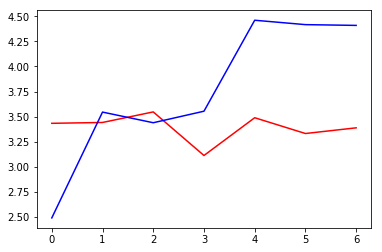

In [0]:
loss_ar = np.array(loss_arr)
val_loss_ar = np.array(val_loss_arr)
plt.plot(loss_ar,'r')
plt.plot(val_loss_ar,'b')
plt.show()

# Testing the Model

In [0]:
transform = transforms.Compose([
  transforms.Resize((256,256)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [0]:
testDataLoader = DataLoader(testData,batch_size = 1, shuffle=False)

In [0]:
tsd = iter(testDataLoader)

In [0]:
model.load_state_dict(torch.load('weight.pth'))
model.eval()

(-0.5, 255.5, 255.5, -0.5)

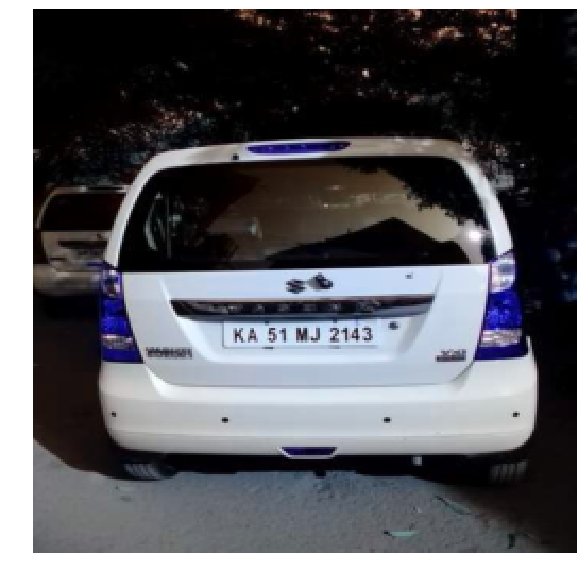

In [239]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


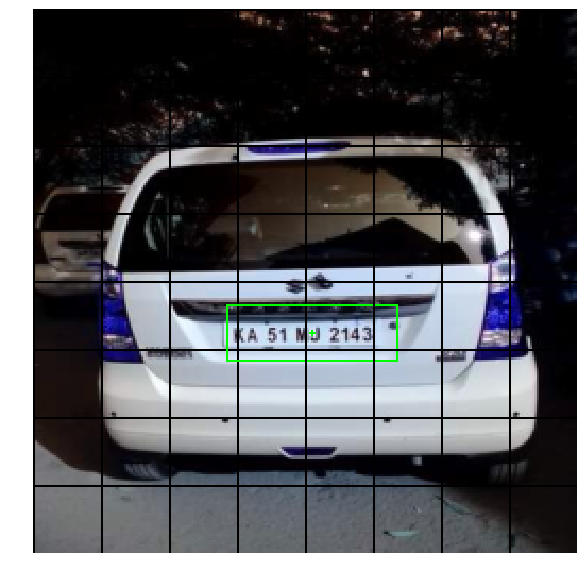

In [240]:

img,x1,y1,x2,y2,imgW,imgH = tsd.next()
output = model(img.cuda()).cpu().detach()
ind = 0
img,x1,y1,x2,y2,imgW,imgH = img[ind],x1[ind],y1[ind],x2[ind],y2[ind],imgW[ind],imgH[ind] 
img = np.transpose(img.numpy(),(1,2,0))
img = img*np.array((0.5, 0.5, 0.5)) +np.array((0.5, 0.5, 0.5))
x1,y1,x2,y2,imgW,imgH = x1.item(),y1.item(),x2.item(),y2.item(),imgW.item(),imgH.item()
x1,y1,x2,y2 = x1*256,y1*256,x2*256,y2*256
step = 256//8
img_f = 0
xc,yc = int((x1+x2)/2),int((y1+y2)/2)
X,Y = int(xc/step),int(yc/step)
im = img.copy()
ground_truth = output.numpy()
for i in range(0,8):
  for j in range(0,8):
    x0,y0 = i*step,j*step
    x1_,y1_ = (i+1)*step,(j+1)*step
    cv2.rectangle(im,(x0,y0),(x1_,y1_),(0,0,0),1)
    if  ground_truth[0,0,i,j]>=0.1:
      xc = int(ground_truth[0,1,i,j]*(x1_ - x0) + x0)
      yc = int(ground_truth[0,2,i,j]*(y1_ - y0) + y0)
      cv2.circle(im,(xc,yc),1,(0,255,0),-1)
      half_x = int(ground_truth[0,3,i,j]*256)
      half_y = int(ground_truth[0,4,i,j]*256)
      img_f = img[yc-half_y:yc+half_y,xc-half_x:xc+half_x,:]
      cv2.rectangle(im,(xc-half_x,yc-half_y),(xc+half_x,yc+half_y),(0,255,0),1)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(im)

True

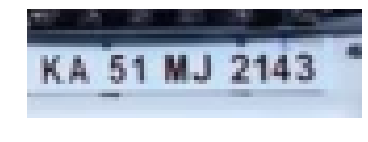

In [241]:
img_f = (img_f*255).astype(int)
plt.imshow(img_f)
plt.axis('off')
cv2.imwrite('h.jpg',img_f)


In [0]:
import pytesseract

KA 51 MJ 2143


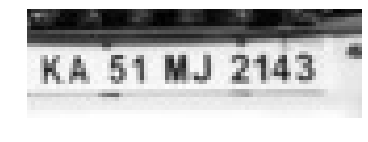

In [243]:
config = ('-l eng --oem 1 --psm 3')
gray = cv2.imread('h.jpg',0)
# gray = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# gray = cv2.medianBlur(gray, 3)
plt.imshow(gray,cmap='gray')
plt.axis('off')
text = pytesseract.image_to_string(gray)

print(text)

In [43]:
# ! add-apt-repository ppa:alex-p/tesseract-ocr
# !sudo apt-get update
# !sudo apt install tesseract-ocr
# !sudo apt install libtesseract-dev
# !sudo pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.0-py2.py3-none-any.whl size=20969 sha256=6228646284197badc845ebe839fb83c2ac5802dbb354dd3dea9552842a339b8b
  Stored in directory: /root/.cache/pip/wheels/78/c9/ac/4cb76bd547f9970070522439e5203ba7926c5c5c4f131583ea
Successfully built pytesseract
